# HookNet

The following part briefly describes the implementation of a HookNet model concluding by discussing its performances in this problem. The implementation of the model has been based from this [paper](https://arxiv.org/pdf/2006.12230v1.pdf). The official implementation (TensorFlow) can be found in this [repository](https://github.com/DIAGNijmegen/pathology-hooknet).

## Implementation notes

The implementation of the model in our repository follows the style of the other models in the `segmentation_models_pytorch` library. Similarly to U-Net it contains for each branch multiple separate nn.Modules representing the encoder, the decoder and the segmentation heads.

The encoders of both branches do not contain any variations and their weights are previuosly exploited to avoid training from scratch as in the previous parts.

On the other hand, the decoder Module used by HookNet is an extension of the original one, since it returns also the features maps computed at each depth similarly to what is normally done by the encoder.

This is necessary to enable the "hooking mechanism" and to capture the features from the context branch that have to be concatenated in the target branch's bottleneck. This operation is performed in the forward method of the HookNet class.

## Dataset

We need to create the dataset containing the contexts, in this scenario the contexts comprise concentric patches of 512x512 pixels. They are similarly retrieved as in the previous models, but we will need to rescale them to the target size which is 256x256.

In [ ]:
img_size = 256
images_path = '../data/images'
masks_path = '../data/masks'

ctx_size = 512
images_ctx_path = '../data/images_ctx'
masks_ctx_path = '../data/masks_ctx'

We need two datasets, one containing images and masks for the target branch, the other for the context branch. Therefore, we start creating these 4 datasets.

In [ ]:
import itertools

from preprocess.dataset import get_training_validation_sets, denormalize_images, HuBMAPDataset
from preprocess.augmentation import get_augmentations
from visualization.visualize_data import visualize

from albumentations import *

training_dataset, training_images, validation_dataset, validation_images = get_training_validation_sets(
    images_path=images_path,
    masks_path=masks_path,
    validation_percentage=0.25, 
    transform={'train': None, 'val': None},
    device=device,
    mean=None,
    std=None
)

# Creates the context datasets
training_dataset_ctx = HuBMAPDataset(list(training_images),
                                     images_ctx_path,
                                     masks_ctx_path,
                                     device=device,
                                     mean=None,
                                     std=None)

validation_dataset_ctx = HuBMAPDataset(list(validation_images),
                                       images_ctx_path,
                                       masks_ctx_path,
                                       device=device,
                                       mean=None,
                                       std=None)

Secondly, we can use a special Dataset extension class called ContextualHuBMAPDataset whose implementation can be found in the repository. This Dataset is not only used to easily return tuples of (image_target, image_context) and (mask_target, mask_context) but to apply the same data augmentations to target and context.

We observed that in this scenario some augmentations might break the dependencies between the target and its context. Dihedral transformations and color augmentations seem to be coherent while, for what concerns distorsions, even if they stretch or shrink equally the images, they actually change different areas of the target and the context images, because the contexts have bigger fields of view and contain contextual information which is not present in target images. We tried to ignore this intuition obtaining bad scores and for this reason we decided to disable this type of augmentations. 

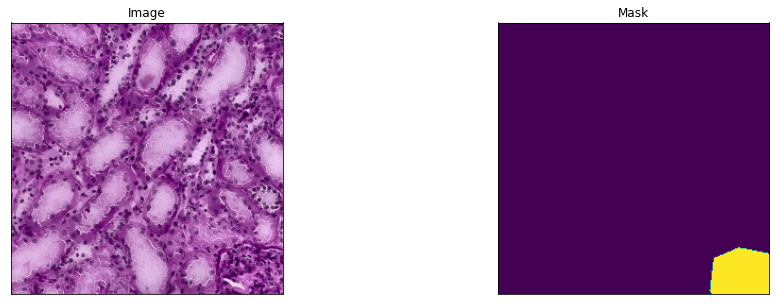

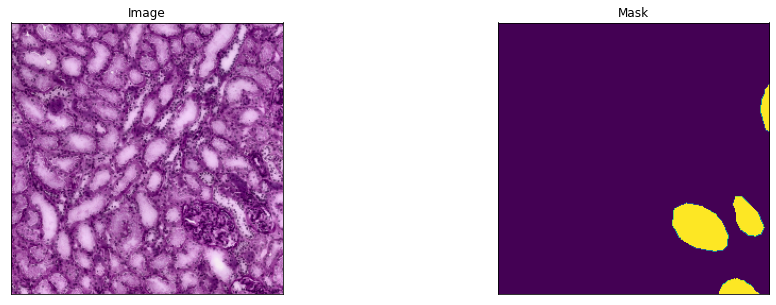

In [ ]:
import itertools
from preprocess.dataset import ContextualHuBMAPDataset, get_training_validation_sets, denormalize_images
from visualization import visualize
from preprocess.augmentation import get_augmentations

hubmap_mean = [0.65459856, 0.48386562, 0.69428385]
hubmap_std = [0.15167958, 0.23584107, 0.13146145]

final_training_dataset = ContextualHuBMAPDataset(training_dataset,
                                                 training_dataset_ctx,
                                                 device,
                                                 2,
                                                 hubmap_mean,
                                                 hubmap_std,
                                                 get_augmentations(
                                                     distortion_p=0,
                                                     targets={'context_image': 'image', 'context_mask': 'mask'}
                                                 ))

final_validation_dataset = ContextualHuBMAPDataset(validation_dataset,
                                                   validation_dataset_ctx,
                                                   device,
                                                   2,
                                                   hubmap_mean,
                                                   hubmap_std)

for image, mask in itertools.islice(final_training_dataset, 33, 34):
    visualize(image=denormalize_images(image[0].cpu(), mean=hubmap_mean, std=hubmap_std), mask=mask[0].cpu())
    visualize(image=denormalize_images(image[1].cpu(), mean=hubmap_mean, std=hubmap_std), mask=mask[1].cpu())

An example of distortion which breaks the link between target and context images. If the feature maps should be aggregated by cropping the image with the corresponding image resolution to guarantee pixel alignment, this discrepancy breaks such conditions. The images below show how the glomeruli on the upper right corner changes its shape. 

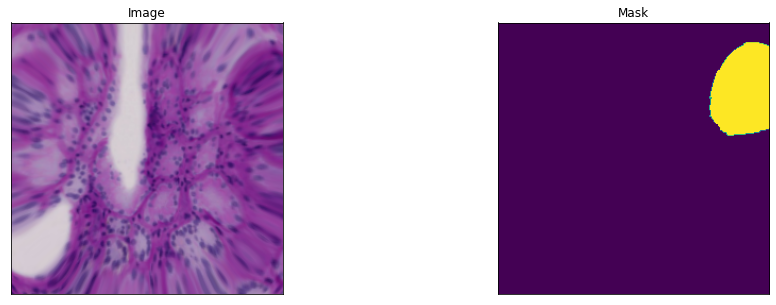

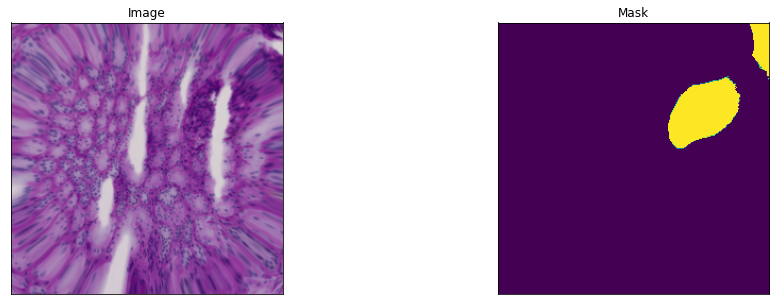

In [ ]:
distorted_dataset = ContextualHuBMAPDataset(validation_dataset,
                                            validation_dataset_ctx,
                                            device,
                                            2,
                                            hubmap_mean,
                                            hubmap_std,
                                            get_augmentations(
                                                distortion_p=1,
                                                targets={'context_image': 'image', 'context_mask': 'mask'}
                                            ))


for image, mask in itertools.islice(distorted_dataset, 2, 3):
    visualize(image=denormalize_images(image[0].cpu(), mean=hubmap_mean, std=hubmap_std), mask=mask[0].cpu())
    visualize(image=denormalize_images(image[1].cpu(), mean=hubmap_mean, std=hubmap_std), mask=mask[1].cpu())

HookNet uses its own loss function, but in principle it is described in the paper as a weighted sum of the cross entropy losses of the two branches. In our implementation we used focal losses experiencing better results with $\alpha$ = 0.5 and $\gamma$ = 0.65. The weight applied to the target loss is called target importance and is set to 0.75, as suggested for one problem described in the paper. 

In [ ]:
from training.loss_functions import HookNetLoss

criterion = HookNetLoss(device=device,
                        alpha=0.5,
                        gamma=0.65,
                        target_importance=0.75)

We obtained the best results exploiting a slightly more sophisticated backbone: EfficientNet-B3 while the number of channels remained the same. We tried also with different upsampling operators, bilinear upsampling, transposed convolutions and nearest neighbors upsampling followed by a convolution as suggested in Odena et al. (2016). We observed slightly better results with the latter. 

The creation of the HookNet prints some details about where the hooking mechanism starts in the context's branch decoder and how the number of channels of the encoder's head is affected.

In [66]:
from models.hooknet import HookNet

target_resolution = 1.0
context_resolution = 2.0

hooknet_depth = 5
hooknet_channels = [64, 32, 16, 8, 4]

hooknet = HookNet(target_resolution,
                  context_resolution,
                  encoder_name='efficientnet-b3',
                  encoder_depth=hooknet_depth,
                  decoder_channels=hooknet_channels,
                  use_transposed_conv=False).to(device)

Hooking occurs at depth 3.0 of the context decoder (channels = [64, 32, 16, 8, 4]).
Number of channels in the encoder's head goes from 384 to 392 with hooking.


## Training

The trainining occurs similarly to the other models, the learning rate is set to a bit smaller value.

In [ ]:
from training.loop import Trainer, TrainerVerbosity, SchedulerWrapper, EarlyStopping
from training.loop import TrainerVerbosity, SchedulerWrapper, EarlyStopping
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

lr = 5e-4
epochs = 20
threshold = 0.5
batch_size = 32

optimizer = Adam(hooknet.parameters(), 
                 lr=lr,
                 weight_decay=0)

trainer = Trainer(threshold,
                  batch_size,
                  final_training_dataset,
                  final_validation_dataset)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

early_stopping = EarlyStopping(num_epochs_to_stop=3)

trainer.train(model=hooknet,
              criterion=criterion,
              optimizer=optimizer,
              epochs=epochs,
              scheduler=scheduler,
              early_stopping=early_stopping,
              verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS],
              evaluation_verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS],
              use_wandb=True);

In [67]:
import torch
hooknet.load_state_dict(torch.load('hooknet_256_512.pt', map_location=torch.device(device)))

<All keys matched successfully>

Experiments can be seen in the [final W&B project](https://wandb.ai/mazzio97/hackingthekidney-report?workspace) and in a [dedicated one](https://wandb.ai/lomb/HackingTheKidney). In particular, the above final model can be seen in the final *W&B* project as the run "hooknet-256-512_best" which obtained the best scores in the validation set. Since HookNet exploits the combination of two U-Nets models, many of the previous approaches performed on the baselines helped to come up with a stronger model. Due to time and computational restrictions we were not able to try HookNet with different resolutions as we initially planned (such as 128:512), but it would be surely interesting.

## Predictions

Similarly to the other models we show some good and bad predictions also here.

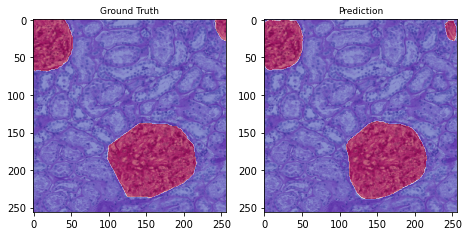

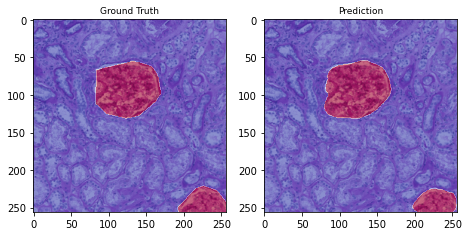

In [88]:
show_predictions(hooknet,
                 images_path,
                 masks_path,
                 hubmap_mean,
                 hubmap_std,
                 images_ctx_path,
                 masks_ctx_path,
                 device,
                 images_to_show=2, 
                 min_score_percentage=90,
                 max_score_percentage=99)

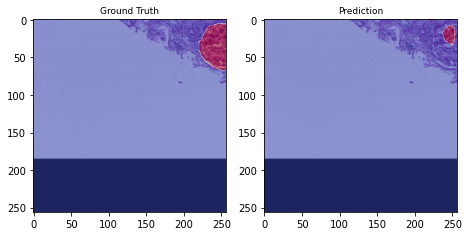

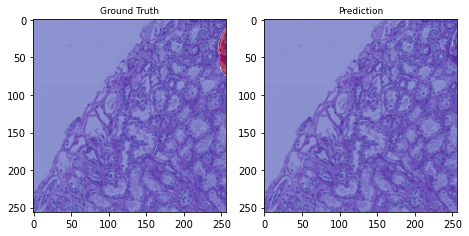

In [92]:
show_predictions(hooknet,
                 images_path,
                 masks_path,
                 hubmap_mean,
                 hubmap_std,
                 images_ctx_path,
                 masks_ctx_path,
                 device,
                 images_to_show=2, 
                 min_score_percentage=1,
                 max_score_percentage=30)

# Final Considerations

In conclusion, we tested different models and tried professional libraries and technologies such as the *Segmentation Models* library, *Albumentations* and *W&B*. We had the opportunity to create from scratch with PyTorch an entire training and testing framework, with custom datasets and utility functions. We explored deeply the semantic segmentation domain and in particular its applications in the medical scenario, exploring a relatively new architecture.

Since the competition during the time of writing was being updated, we worked with many wrong annotations and a limited amount of available data. Nevertheless, in general we consider our results discrete and comparable with many other competing teams. If we will continue this challenge we would like to define better the post processing phase and explore region based semantic segmentation models since the shape of the glomerulis is maintained similar in the whole dataset.

## Models Comparison

We conclude by showing some hard images and their predictions using the different models presented throughout this report.

Obviuosly, it is not possible to come up with concrete considerations from a few images, some of the results are also controversial, there are cases where the unregularized U-Net seems to perform better. We believe that the scores measured overall are better in the more complex models because they are more accurate in defining the FTU boundaries and less prone to false positives, while in certain cases, the high variance of the classical U-Net is beneficial to get some results.

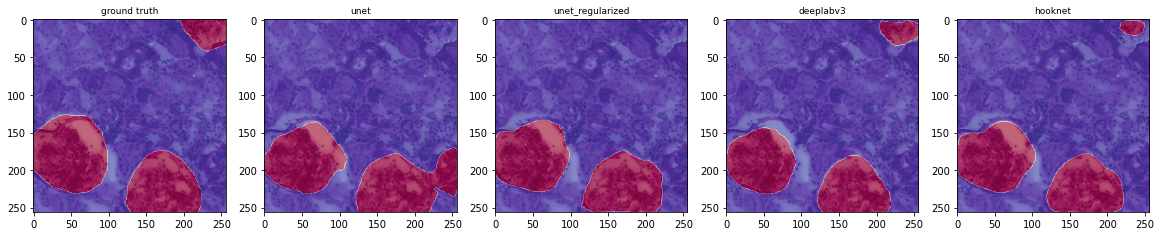

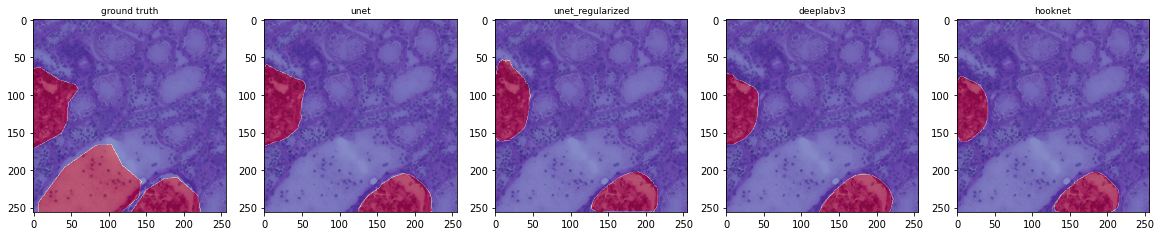

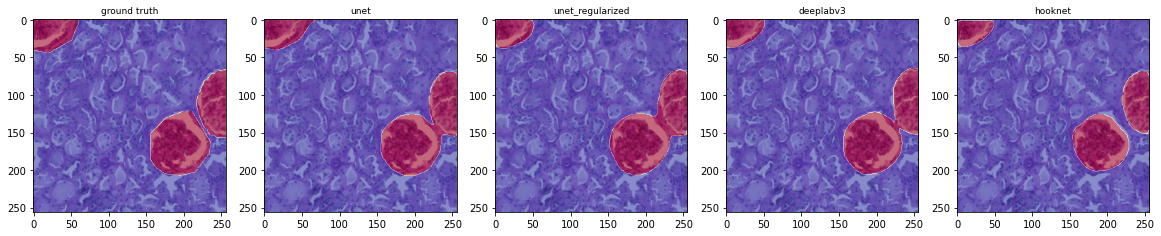

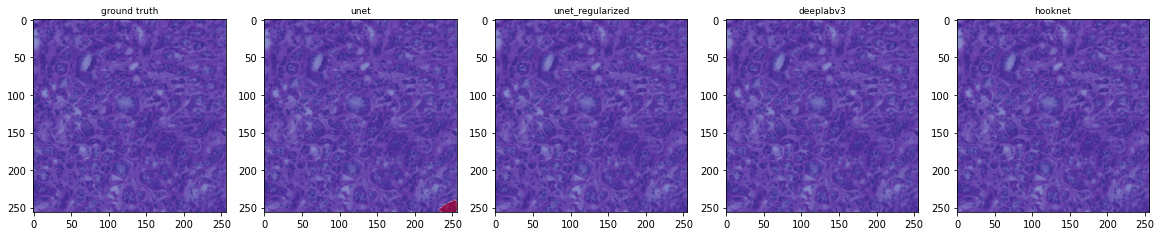

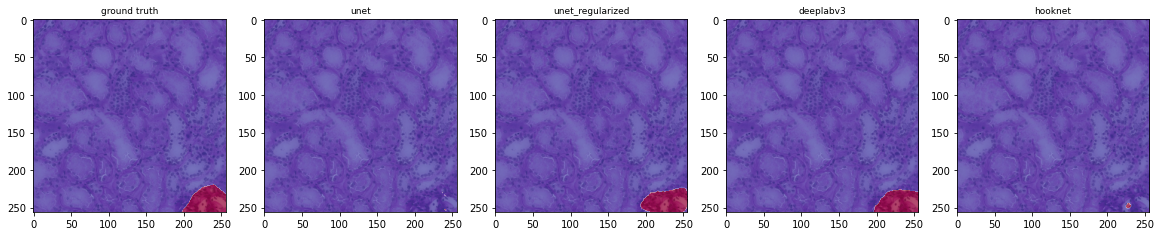

In [94]:
from utils import convert_to_tensors
from visualization import display_images_and_masks
import numpy as np
from torchvision.transforms import transforms
from typing import List

models = [unet, unet_regularized, deeplabv3, hooknet]


def get_images_masks_pairs_with_contexts(filenames: List):
    images_masks = []
    contexts_masks = []

    for filename in filenames:
        images_masks.append(convert_to_tensors(os.path.join(images_path, filename),
                                               os.path.join(masks_path, filename),
                                               hubmap_mean,
                                               hubmap_std,
                                               device=device))
        
        contexts_masks.append(convert_to_tensors(os.path.join(images_ctx_path, filename),
                                                 os.path.join(masks_ctx_path, filename),
                                                 hubmap_mean,
                                                 hubmap_std,
                                                 device=device))
    return images_masks, contexts_masks

difficult_images_filenames = ['095bf7a1f_285.png', 
                              '095bf7a1f_921.png', 
                              'e79de561c_359.png', 
                              '1e2425f28_120.png',
                              '095bf7a1f_718.png']

difficult_images, difficult_images_contexts = get_images_masks_pairs_with_contexts(difficult_images_filenames)


labels = ['ground truth', 
          'unet',
          'unet_regularized',
          'deeplabv3',
          'hooknet']

with torch.no_grad():
    for i, (image, mask) in enumerate(difficult_images):
        preds = [mask.cpu()]
        for model in models:
            model.eval()
            if type(model) is HookNet:
                output = model((image.unsqueeze(0), 
                                difficult_images_contexts[i][0].unsqueeze(0)))
                preds.append((output[0].squeeze().cpu().numpy() > 0.5).astype(np.uint8))
            else:
                output = model(image.unsqueeze(0))
                preds.append((output.squeeze().cpu().numpy() > 0.5).astype(np.uint8))


        display_images_and_masks([transforms.ToPILImage()(
                                     denormalize_images(image.cpu(), 
                                                        mean=hubmap_mean, 
                                                        std=hubmap_std)
                                 )] * len(preds),
                                 preds,
                                 labels)